### 线性回归
算法推导过程中已经给出了求解方法，基于最小二乘法直接求解，但这并不是机器学习的思想，由此引入了梯度下降方法。该实验重点理解梯度下降每一步流程与实验对比分析

#### 主要内容
- 线性回归方程实现
- 梯度下降效果
- 对比不同梯度下降策略
- 建模曲线分析
- 过拟合与欠拟合
- 正则化作用
- 提前停止策略

In [1]:
%matplotlib inline

import os
import warnings

from matplotlib import pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#### 回归方程：
![回归方程](../images/linear.png)

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

(0.0, 2.0, 0.0, 15.0)

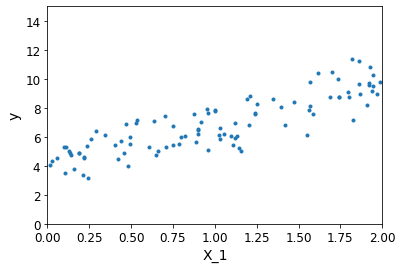

In [3]:
plt.plot(X, y, '.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([0,2, 0, 15])

#### 参数直接求解法

In [4]:
X_b = np.c_[np.ones((100, 1)), X]
# np.linalg.inv求逆
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

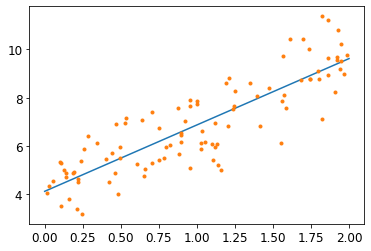

In [6]:
plt.plot(X_new, y_predict, '-')
plt.plot(X, y, '.')

#### sklearn API文档：
https://scikit-learn.org/stable/modules/classes.html



#### 工具包实现

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)
print(reg.coef_)
print(reg.intercept_)

[[2.75085238]]
[4.12007657]


### 梯度下降
![梯度下降原理](../images/gradient.png)

- 问题：步长太小
![步长太小](../images/gradient_step_low.png)

- 问题：步长太大
![步长太大](../images/gradient_step_high.png)

- 遇到的问题
![收敛的问题](../images/5.png)

- 标准化的作用
![标准化的作用](../images/6.png)

- 批量梯度下降
![批量梯度下降](../images/7.png)

In [8]:
eta = 0.1  # 学习率
n_iterations = 100  # 迭代次数
m = 100
theta = np.random.randn(2, 1)
for i in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradient


In [9]:
X_new_b.dot(theta)

array([[4.08967953],
       [9.64231659]])

#### 学习率对结果的影响

In [10]:
theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    n_iterations = 1000  # 迭代次数
    m = len(X_b)
    plt.plot(X, y, 'b.')
    for i in range(n_iterations):
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, 'r-')
        gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradient
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('X_1')
    plt.axis([0, 2, 0, 15])
    plt.title('eta={}'.format(eta))

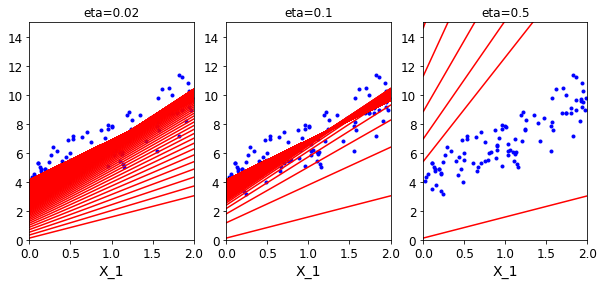

In [11]:
theta = np.random.randn(2, 1)
plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)

#### 随机梯度下降

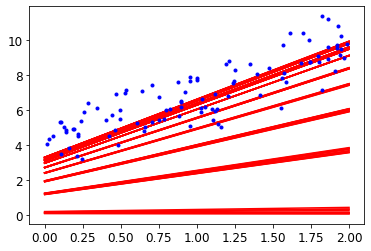

In [12]:
theta_path_sgd = []
m = len(X_b)
n_epochs = 50

t0 = 5
t1 = 50

theta = np.random.randn(2,1)

def learning_schedule(t):
    return t0/(t1+t)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch < 10 and i < 10:  # 只展示部分，因全部展示，效果不明显
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, 'r-')
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(n_epochs*m+i)
        theta = theta - eta * gradient
        theta_path_sgd.append(theta)
plt.plot(X, y, 'b.')

#### 小批量梯度下降

In [13]:
theta_path_mgd=[]
n_epochs = 50
minibatch = 16
theta = np.random.randn(2,1)
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)
np.random.seed(42)
t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)  # 数据打乱/洗牌
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch):
        t += 1
        xi = X_b_shuffled[i:i+minibatch]
        yi = y_shuffled[i:i+minibatch]
        gradient = 2 / minibatch * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradient
        theta_path_mgd.append(theta)

#### 3种策略的对比实验

In [14]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

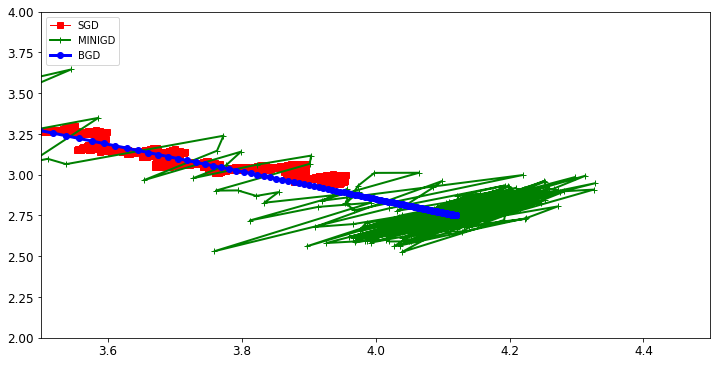

In [15]:
plt.figure(figsize=(12,6))
plt.plot(theta_path_sgd[:,0],theta_path_sgd[:,1],'r-s',linewidth=1,label='SGD')
plt.plot(theta_path_mgd[:,0],theta_path_mgd[:,1],'g-+',linewidth=2,label='MINIGD')
plt.plot(theta_path_bgd[:,0],theta_path_bgd[:,1],'b-o',linewidth=3,label='BGD')
plt.legend(loc='upper left')
plt.axis([3.5,4.5,2.0,4.0])
plt.show()

从上图可知， 全量梯度下降效果好，但是十分耗时。
实际当中用小批量梯度下降较多，一般情况下选择batch数量应当越大越好